# electricity_market_player

> This module training optimizing and evaluation of RL agent on the electricity market environment.
using PPO with actions mask.

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from scipy import stats
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly

from electricity_market.electricity_market_env import ElectricityMarketEnv


In [ ]:
#| export
TOTAL_TIMESTEPS = 10 # 100_000
N_EPISODES = 10
N_TRAILS = 10
N_JOBS = 7
seeds = [123456] #, 234567, 345678, 456789, 567890]
if TOTAL_TIMESTEPS % N_EPISODES != 0:
    raise ValueError("Total_timesteps must be a multiple of n_episodes")
frames = np.array(list(range(TOTAL_TIMESTEPS // N_EPISODES, TOTAL_TIMESTEPS + 1, TOTAL_TIMESTEPS // N_EPISODES)), dtype=int)

# Decided On granularity of 100 Wh
env_config = {
    "max_timestep": TOTAL_TIMESTEPS,
}
results = {}

In [ ]:
#| export
def collect_episode_rewards(model: MaskablePPO, env: ElectricityMarketEnv, n_episodes: int = N_EPISODES, deterministic: bool = True, render: bool = False):
    episode_rewards, _ = evaluate_policy(
        model, env, deterministic=deterministic, use_masking=True,
        return_episode_rewards=True, n_eval_episodes=n_episodes, render=render
    )
    return episode_rewards


def mask_fn(env: ElectricityMarketEnv) -> np.ndarray:
    return env.action_masks()

In [ ]:
#| export
def evaluate_maskable_ppo_on_environment(hyperparameters: dict | None = None, n_episodes: int = N_EPISODES, render: bool = False):
    global seeds, frames, env_config

    if hyperparameters is None:
        hyperparameters = {}
    all_rewards = []

    for seed in seeds:
        print(f"\nRunning experiment with seed {seed}...")
        env = DummyVecEnv([
            lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), mask_fn))
        ])

        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            verbose=0,
            seed=seed,
            **hyperparameters
        )

        seed_rewards = []

        for frame in frames:
            model.learn(total_timesteps=frame, use_masking=True, reset_num_timesteps=False)
            rewards = collect_episode_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=render)
            seed_rewards.append(rewards)

        seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
        all_rewards.append(seed_rewards)

    all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
    print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
    return all_rewards

In [ ]:
#| export
def plot_evaluation_results(evaluation_results: dict) -> None:
    global seeds, frames, env_config
    # Extract algorithm names (which are actually keys in the dictionary)
    algorithms = list(evaluation_results.keys())

    # Function to compute aggregate metrics (median, IQM, mean) for each checkpoint and seed
    def aggregate_func(x):
        return np.array([
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x),
        ])

    # For each algorithm, we need to apply aggregate_func to the data (which has the shape (num_seeds, num_checkpoints, num_episodes))
    def aggregate_over_checkpoints(evaluation_results):
        aggregated_results = {}
        for algorithm, results in evaluation_results.items():
            # results.shape is (num_seeds, num_checkpoints, num_episodes)
            # We aggregate across seeds and episodes for each checkpoint
            agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
            aggregated_results[algorithm] = agg_results
        return aggregated_results

    # Aggregate results across seeds and episodes
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Use rly to compute interval estimates
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    # Plot aggregate metrics (Median, IQM, Mean)
    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

    # =============================================================================
    # 2. Probability of Improvement (if comparing two algorithms)
    # =============================================================================
    if len(algorithms) == 2:
        alg1, alg2 = algorithms
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

    # =============================================================================
    # 3. Sample Efficiency Curve (using frames as defined in the evaluation function)
    # =============================================================================
    sample_efficiency_dict = {
        alg: results[:, 1:, :]  # We want to remove the first checkpoint as it's usually 0
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    # Define the IQM function
    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(scores.shape[2])])

    # Compute IQM scores and confidence intervals using rly
    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)
    # Plot the sample efficiency curve
    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()


    # =============================================================================
    # 4. Performance Profiles (linear and non-linear scaling)
    # =============================================================================
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    # ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()



In [ ]:
#| export
def optimize_maskable_ppo_agent(trial, n_episodes: int = N_EPISODES):
    global seeds
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_int('n_steps', 32, 1024, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 256, log=True)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 1.0)
    ent_coef = trial.suggest_float('ent_coef', 0.0, 0.02)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.1, 1.0)

    trial_seed_rewards = []

    for seed in seeds:
        env = DummyVecEnv([
            lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config, render_mode="human"), mask_fn))
        ])

        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            batch_size=batch_size,
            gamma=gamma,
            gae_lambda=gae_lambda,
            ent_coef=ent_coef,
            vf_coef=vf_coef,
            clip_range=clip_range,
            max_grad_norm=max_grad_norm,
            verbose=0,
            seed=seed
        )

        model.learn(total_timesteps=TOTAL_TIMESTEPS, use_masking=True)
        episode_rewards = collect_episode_rewards(model, env, n_episodes=n_episodes, deterministic=True, render=False)

        seed_avg_reward = np.mean(episode_rewards)
        trial_seed_rewards.append(seed_avg_reward)
    aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

    return aggregated_performance

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPO_Baseline"] = evaluate_maskable_ppo_on_environment(hyperparameters=None, n_episodes=N_EPISODES, render=True)


Running experiment with seed 123456...


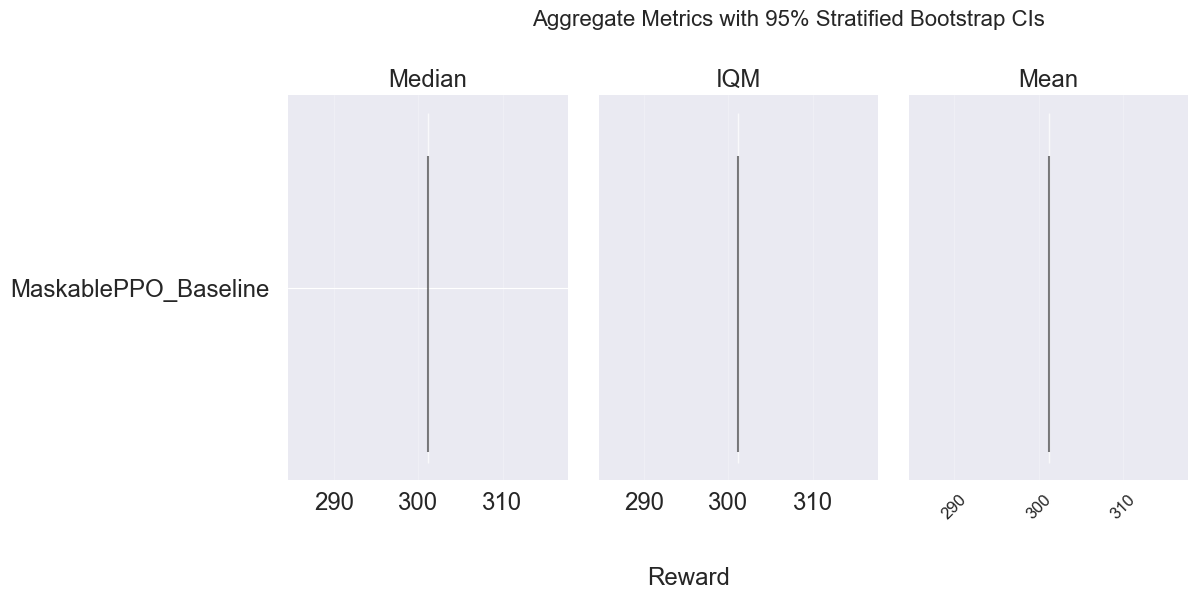

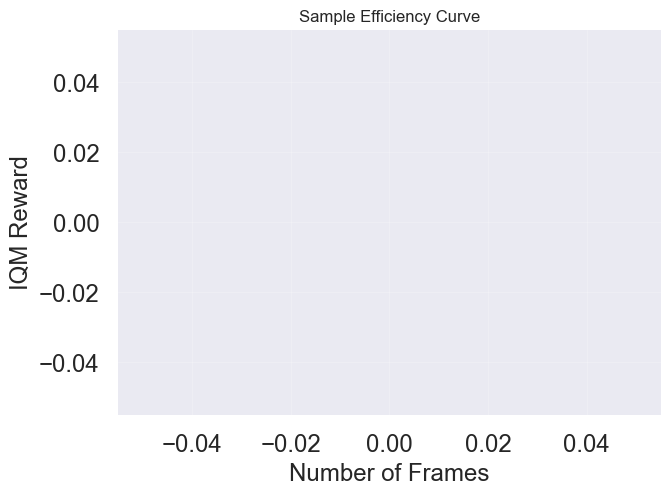

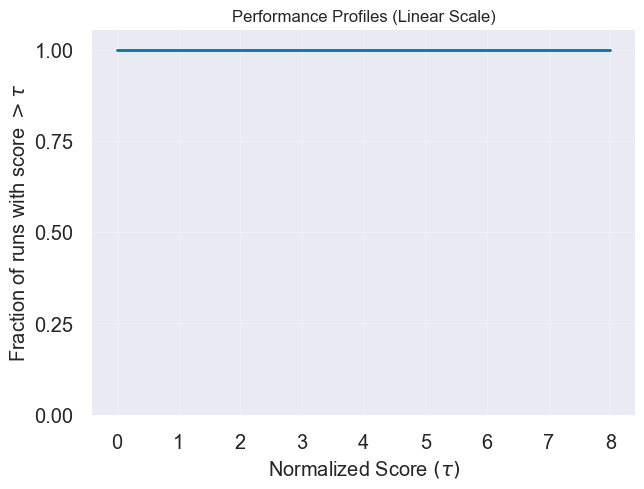

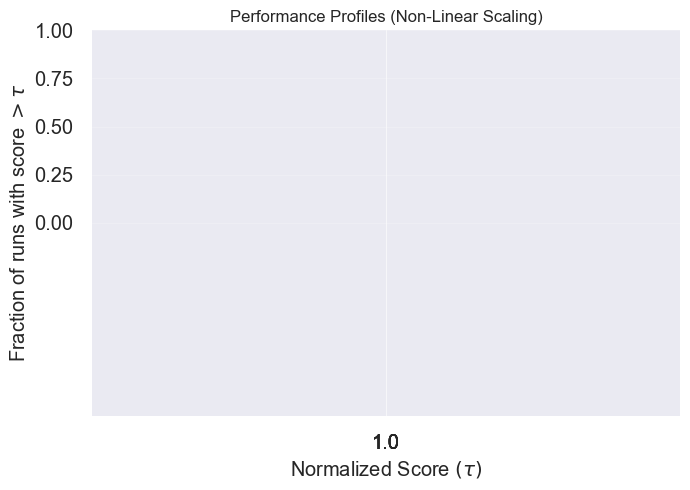

In [ ]:
#| export
plot_evaluation_results(results)

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(optimize_maskable_ppo_agent, n_trials=N_TRAILS, n_jobs=N_JOBS)

print("Best trial:", study.best_trial)

[I 2025-02-11 11:57:54,284] A new study created in memory with name: no-name-6555db0a-054a-4545-9003-c2cd6117f459

KeyboardInterrupt



### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPO_Optimized"] = evaluate_maskable_ppo_on_environment(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES, render=True)

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()